In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrdog123","key":"35288ba7227552ae60e10a140227ad66"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 331M/331M [00:18<00:00, 20.0MB/s]
100% 331M/331M [00:18<00:00, 18.5MB/s]


In [7]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [8]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [9]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [10]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [11]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [12]:
len(age)

23708

In [13]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [14]:
df.head()

,age,gender,img
0,42,0,42_0_4_20170104174008963.jpg.chip.jpg
1,35,0,35_0_0_20170113210127529.jpg.chip.jpg
2,1,1,1_1_4_20170103210113314.jpg.chip.jpg
3,60,1,60_1_1_20170113011821480.jpg.chip.jpg
4,46,0,46_0_0_20170104203859666.jpg.chip.jpg


In [15]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_dataset = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output')

test_dataset = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                  class_mode='multi_output')


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [18]:
IMG_SIZE = (200,200,3) ;

In [19]:
from keras.initializers import he_uniform

In [20]:
input_shape=(200, 200 , 3)
base_model = keras.applications.ResNet50(
  include_top=False ,
  weights="imagenet",
  input_shape=(200, 200 , 3))
base_model.trainable = True ;
fine_tune_at = 130 ;
for layer in base_model.layers[:fine_tune_at]  :
    layer.trainable = False ;
output = base_model.layers[-1].output
output = tfl.GlobalAveragePooling2D()(output)
output = tfl.Dropout(0.2)(output)
flatten = Flatten()(output)

dense1 = Dense(512, activation='relu', kernel_initializer=he_uniform())(flatten)
dense2 = Dense(512,activation='relu', kernel_initializer=he_uniform())(flatten)

dense3 = Dense(512,activation='relu',kernel_initializer=he_uniform())(dense1)
dense4 = Dense(512,activation='relu',kernel_initializer=he_uniform())(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

94765736/94765736 [==============================] - 5s 0us/step


In [21]:
model = Model(inputs=base_model.input,outputs=[output1,output2])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [24]:
model.fit(train_dataset, batch_size=32, epochs=15, validation_data=test_dataset)

Epoch 1/15
625/625 [==============================] - 266s 425ms/step - loss: 74.6805 - age_loss: 14.2005 - gender_loss: 0.6109 - age_mae: 14.2005 - gender_accuracy: 0.6754 - val_loss: 240.6490 - val_age_loss: 56.0962 - val_gender_loss: 1.8642 - val_age_mae: 56.0962 - val_gender_accuracy: 0.5418
Epoch 2/15
625/625 [==============================] - 273s 436ms/step - loss: 73.1807 - age_loss: 14.1070 - gender_loss: 0.5967 - age_mae: 14.1070 - gender_accuracy: 0.6824 - val_loss: 106.9314 - val_age_loss: 17.2010 - val_gender_loss: 0.9064 - val_age_mae: 17.2010 - val_gender_accuracy: 0.5332
Epoch 3/15
625/625 [==============================] - 256s 409ms/step - loss: 72.3643 - age_loss: 13.9749 - gender_loss: 0.5898 - age_mae: 13.9749 - gender_accuracy: 0.6905 - val_loss: 160.7526 - val_age_loss: 34.4463 - val_gender_loss: 1.2758 - val_age_mae: 34.4463 - val_gender_accuracy: 0.5235
Epoch 4/15
625/625 [==============================] - 255s 409ms/step - loss: 71.3696 - age_loss: 13.7526 - g

In [25]:
keras.src.callbacks.History

keras.src.callbacks.History

In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = '/content/crop_part1/101_1_2_20170105174739309.jpg.chip.jpg'
img = image.load_img(img_path, target_size=(200, 200))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

img_array = img_array / 255.0

# Make a prediction
predictions = model.predict(img_array)

# Interpret the predictions
predicted_age = predictions[0][0]
predicted_gender = predictions[1][0]

# Gender prediction is a sigmoid output, so interpret it as a probability
predicted_gender_label = 'Male' if predicted_gender >= 0.5 else 'Female'

# Output the results
print(f"Predicted age: {predicted_age}")
print(f"Predicted gender: {predicted_gender_label} (probability: {predicted_gender})")


1/1 [==============================] - 0s 23ms/step
Predicted age: [65.125626]
Predicted gender: Female (probability: [0.22016329])


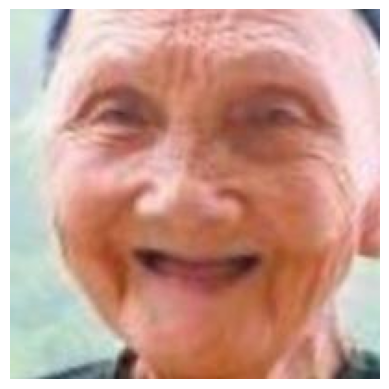

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = '/content/crop_part1/101_1_2_20170105174739309.jpg.chip.jpg'  # Replace with the path to your image
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()